# Comparison of LDA and PCA models. Machine Learning Fashionista.



## Step 1. Downloading, processing and preparing data 

### 1.1 Downloading and saving the images 

In [1]:
# Ignore the Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import libraries used in the notebook
import collections
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread_collection
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set()


In [3]:
# Creating paths for the local male and female clothing directories 
male_dir = 'male_cloth/*.JPEG'
female_dir = 'female_cloth/*.JPEG'

# Bulk reading of the images and loading as a collection
male = imread_collection(male_dir)
female = imread_collection(female_dir)

In [4]:
# 
print(f"There are {len(male)} male clothes in the collection.")
print(f"There are {len(female)} female clothes in the collection.")

There are 1242 male clothes in the collection.
There are 1270 female clothes in the collection.


#### Both of the image collectioons are close in the number. Hence, our collections would be balanced and we do not need to truncate manually our collections.  

### 1.2 Resizing the collections

In [5]:
# Resizing images to a uniform size 

# Setting the standart height and width for all images
target_height = 200
target_width = 200
    
# Resizing the images in each collection
male_resized = [resize(male[i],(target_height,target_width), mode='constant') for i in range(len(male))]
female_resized = [resize(female[i],(target_height,target_width), mode='constant') for i in range(len(female))]


#### Showing the images before and after the resizing for each collection.

Text(1.0, 1.0, 'Female Clothing Resized Images')

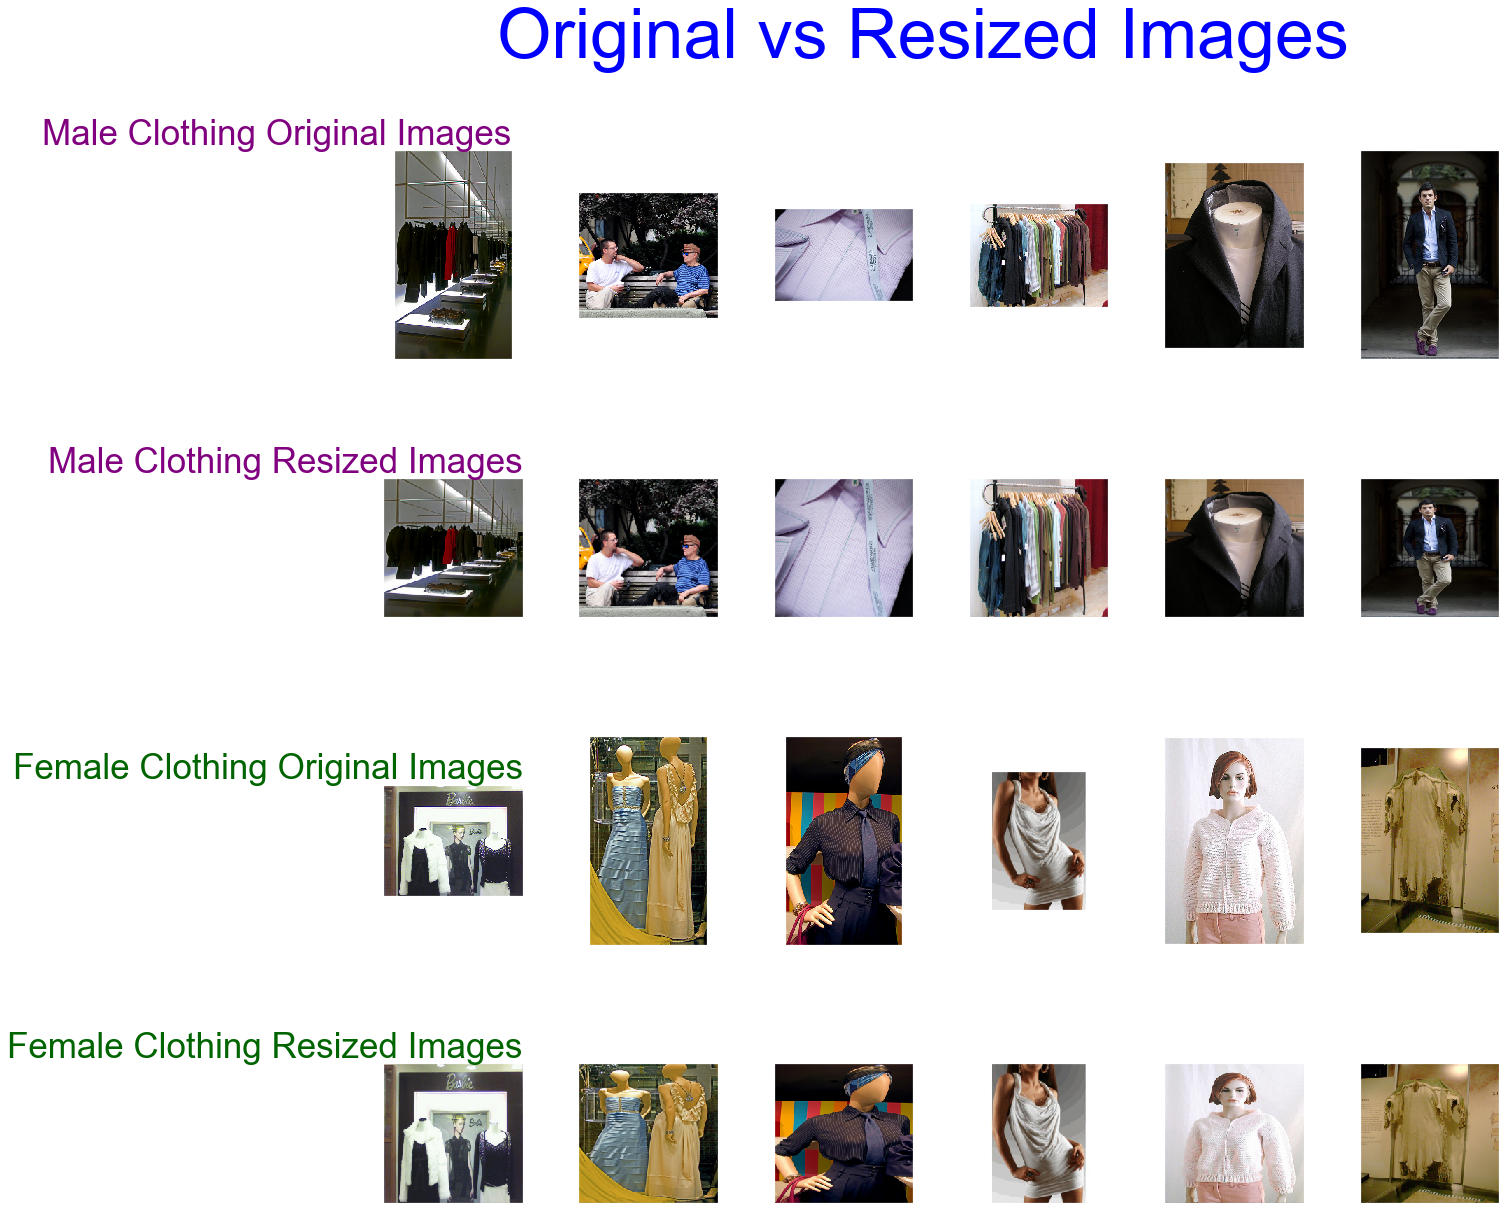

In [6]:
fig, axarr = plt.subplots(4, 6, figsize=(20, 20),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.4, wspace=0.4))

# Creating the row-by-row comparisions for both male and female images
for i in range(6):
    axarr[0, i].imshow(male[i])
    axarr[1, i].imshow(male_resized[i])
    axarr[2, i].imshow(female[i])
    axarr[3, i].imshow(female_resized[i])

fig.suptitle("Original vs Resized Images", fontsize=70, color = "blue")
axarr[0, 0].set_title('Male Clothing Original Images', size=35, color = "purple", loc='right')
axarr[1, 0].set_title('Male Clothing Resized Images', size=35,  color = "purple", loc='right')
axarr[2, 0].set_title('Female Clothing Original Images', size=35, color = "darkgreen", loc='right')
axarr[3, 0].set_title('Female Clothing Resized Images', size=35,color = "darkgreen", loc='right')


### 1.3  Flattening the resized collection

After uniforming the size, we flatten the image collections to 3-dimensions consiting of height, weight and RGB for each image. 

In [7]:
# Flattening the collections 
male_flat = np.array([i.flatten() for i in male_resized])
female_flat = np.array([i.flatten() for i in female_resized])

print('Resized length male clothing data:', male_flat.shape)
print('Resized length women clothing data:', female_flat.shape)

Resized length male clothing data: (1242, 120000)
Resized length women clothing data: (1270, 120000)


### 1.4 Labeling collections and combining them together

In [8]:
# Label each category: 1 for female and 0 for male 
female_label = np.ones(len(female_flat))
male_label = np.zeros(len(male_flat))

# Combine both the datasets together 
X_clothing = np.concatenate((female_flat, male_flat), axis=0)
# Create a variable for label data
y_clothing = np.concatenate((female_label, male_label), axis=0)

In [9]:
print("Female labels count:", female_label.shape[0])
print("Male labels count:", male_label.shape[0])

Female labels count: 1270
Male labels count: 1242


As we will be using logistic classifier, I decided to further standardize by centering the feature columns at mean 0 with standard deviation 1 so that the feature columns take the form of a normal distribution, which makes it easier to learn the weights. I chose the Standart Scaler as some images are strikingly different from others, so we want our model to be less sensetive to outliers while maintaining the useful information about them. 

In [10]:
# Standardize data by removing the mean and scalng each featuree to unit variance

scaler = StandardScaler()
scaler.fit(X_clothing)

X_clothing = scaler.transform(X_clothing)

In [11]:
# Recheck size after the transformations
print('Size of combined dataset:', X_clothing.shape[0])
print('Size of combined dataset labels:', y_clothing.shape[0])

Size of combined dataset: 2512
Size of combined dataset labels: 2512


## Step 2. Splitting the data

In [12]:
# Split dataset into 80% training data and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X_clothing, y_clothing, test_size=0.2, stratify = y_clothing, random_state=1)


In [13]:
print("Count of images in the train set: ", X_train.shape[0])
print("Count of images in the test set: ", X_test.shape[0])
print("Count of female (1) and male(0) images in Train: \n1s: ", collections.Counter(y_train)[1], "and 0s:", collections.Counter(y_train)[0])
print("Count of female (1) and male(0) images in Test: \n1s: ", collections.Counter(y_test)[1], "and 0s:", collections.Counter(y_test)[0])



Count of images in the train set:  2009
Count of images in the test set:  503
Count of female (1) and male(0) images in Train: 
1s:  1016 and 0s: 993
Count of female (1) and male(0) images in Test: 
1s:  254 and 0s: 249


## Step 3. Building a simple linear classifier using the original pixel data: Logistic Regression 

To avoid overfitting, we will use Logistic Regression CV with cross-validation for regularization values. Also, as we have a simple variation in the size of the female and male clothing, we will apply "balanced" to the class weights to alter the loss function by weighting the loss of each sample by its class weight.

In [14]:
log_reg = LogisticRegressionCV(Cs=10, class_weight='balanced').fit(X_train, y_train)


## What is our error rate on the training data?


In [15]:
labels = ["Male", "Female"]

In [16]:
print("\033[1m"+ "Logistic Regression Model Performance on Train Data\n")
print("\033[0m" + f"An array of regularization values used for cross-validation: \n{log_reg.Cs_}\n")
print(f"The regularization value mapping to the best accuracy score: \n{log_reg.C_[0]}\n")
print(f"Mean cross-validation accuracy score: \n{round(np.mean(log_reg.scores_[1]*100), 3)}%\n")

print(f"Classification report:\n{classification_report(y_train, log_reg.predict(X_train), target_names=labels)}")
print("Accuracy score on the training data: " + "\033[1m" + f"{round(log_reg.score(X_train, y_train)*100, 3)}%")




Logistic Regression Model Performance on Train Data

An array of regularization values used for cross-validation: 
[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]

The regularization value mapping to the best accuracy score: 
0.000774263682681127

Mean cross-validation accuracy score: 
64.486%

Classification report:
              precision    recall  f1-score   support

        Male       0.99      0.99      0.99       993
      Female       0.99      0.99      0.99      1016

    accuracy                           0.99      2009
   macro avg       0.99      0.99      0.99      2009
weighted avg       0.99      0.99      0.99      2009

Accuracy score on the training data: 99.054%


## What is our error rate on the orginal testing data?



In [17]:
y_pred = log_reg.predict(X_test)
print("\033[1m"+ "Logistic Regression Model Performance on Test Data\n")
print("\033[0m" + f"Classification report: \n{classification_report(y_test, y_pred, target_names=labels)}")
print("Accuracy score on the testing data: " + "\033[1m" + f"{round(log_reg.score(X_test, y_test)*100, 3)}%\n")



Logistic Regression Model Performance on Test Data

Classification report: 
              precision    recall  f1-score   support

        Male       0.61      0.65      0.63       249
      Female       0.63      0.59      0.61       254

    accuracy                           0.62       503
   macro avg       0.62      0.62      0.62       503
weighted avg       0.62      0.62      0.62       503

Accuracy score on the testing data: 62.028%



We will also look at the Area under ROC curve for each model.

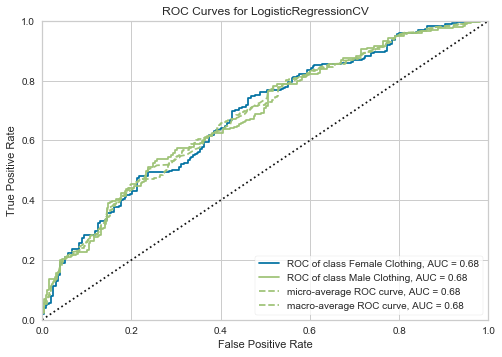

In [18]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(log_reg, classes=["Female Clothing", "Male Clothing"])

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()

## Step 4. PCA application on the logistic regression model

### 4.1 Picking number of components for PCA.

Our original dataset is 120000 dimensional, hence, we will aim at reducing it. I will try to reduce below 300 components, hence, I will look at the first 300 principal components deconstruction. I will be using radomized solver as it will be faster.

In [19]:
pca = PCA(n_components = 300, svd_solver='randomized').fit(X_train, y_train)
pca_components_train = pca.transform(X_train)  


In [20]:
print("PCA-transformed shape of our train dataset: ", pca_components_train.shape[1])

PCA-transformed shape of our train dataset:  300


Text(0, 0.5, 'Cumulative explained variance')

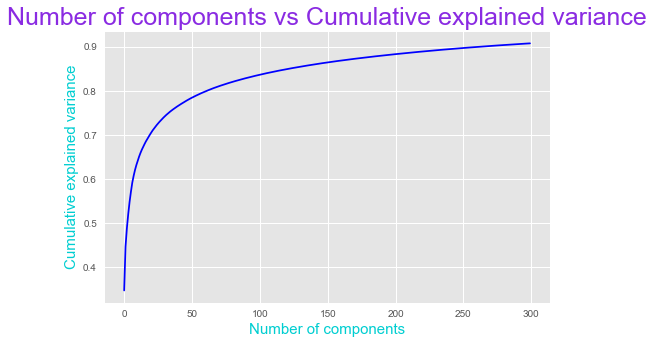

In [21]:
# Visualizing the % of explained variance across 250 components
plt.figure(figsize=(8,5))
plt.style.use("ggplot")
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = "blue")
plt.title("Number of components vs Cumulative explained variance", size=25, color = "blueviolet")
plt.xlabel("Number of components", size=15, color = "darkturquoise")
plt.ylabel("Cumulative explained variance", size=15, color = "darkturquoise")

From the plot, we can see that first 250 principal components are responsible for 90% of explained variance. Hence, we will train our model with 250 components.

In [22]:
pca = PCA(n_components = 250, svd_solver='randomized').fit(X_train, y_train)
pca_train = pca.transform(X_train)  



### 4.2 Contrasting orginal and reduced dimentionality images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Text(1.0, 1.0, 'Image using first \n 250 components')

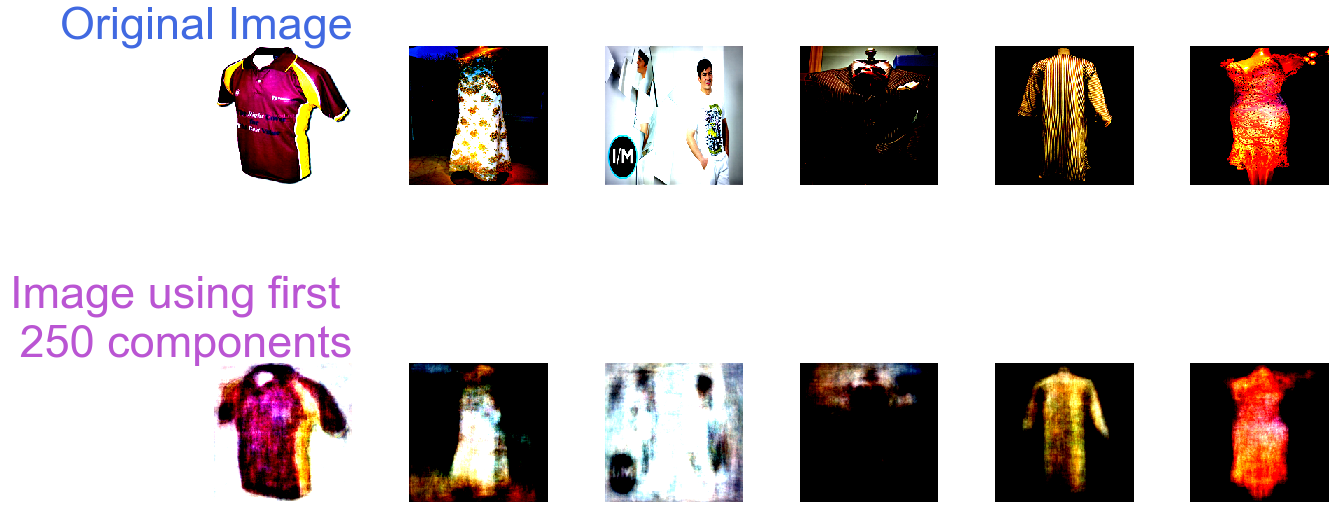

In [23]:
# Projecting image data into 250 dimentional space 
pca_proj = pca.inverse_transform(pca_train)

fig, axarr = plt.subplots(2, 6, figsize=(20, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.4, wspace=0.4))
for i in range(6):
    axarr[0, i].imshow(X_train[i].reshape(target_height, target_width,3))
    axarr[1, i].imshow(pca_proj[i].reshape(target_height, target_width,3))
    
axarr[0, 0].set_title('Original Image', size=45, color = "royalblue", loc='right')
axarr[1, 0].set_title('Image using first \n 250 components', size=45, color = "mediumorchid", loc='right')


As we can see from the reconstruction images above, 250-dimensional reconstruction gives as a general idea of what the original image was very well as it captures main colors and shape.

### 4.3 Train the Logistic Regression Model on the reduced representation that you created using PCA.

We will again use 10-fold cross-validation to find best model parameters.

In [24]:
pca_log_reg = LogisticRegressionCV(Cs=10, class_weight='balanced').fit(pca_train, y_train)


## What is our error rate on the training data with PCA?

In [25]:
print("\033[1m"+ "Logistic Regression Model with PCA Performance on Train Data\n")
print("\033[0m" + f"An array of regularization values used for cross-validation: \n{pca_log_reg.Cs_}\n")
print(f"The regularization value mapping to the best accuracy score: \n{pca_log_reg.C_[0]}\n")
print(f"Mean cross-validation accuracy score: \n{round(np.mean(pca_log_reg.scores_[1]*100), 3)}%\n")

print(f"Classification report:\n{classification_report(y_train, pca_log_reg.predict(pca_train), target_names=labels)}")
print("Accuracy score on the training data: " + "\033[1m" + f"{round(pca_log_reg.score(pca_train, y_train)*100, 3)}%")



Logistic Regression Model with PCA Performance on Train Data

An array of regularization values used for cross-validation: 
[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]

The regularization value mapping to the best accuracy score: 
0.0001

Mean cross-validation accuracy score: 
62.251%

Classification report:
              precision    recall  f1-score   support

        Male       0.72      0.72      0.72       993
      Female       0.73      0.73      0.73      1016

    accuracy                           0.72      2009
   macro avg       0.72      0.72      0.72      2009
weighted avg       0.72      0.72      0.72      2009

Accuracy score on the training data: 72.374%


## What is our error rate on the testing data with PCA?


In [26]:
pca_test = pca.transform(X_test)

pca_pred = pca_log_reg.predict(pca_test)

print("\033[1m"+ "Logistic Regression Model PCA Performance on Test Data\n")
print("\033[0m" + f"Classification report: \n{classification_report(y_test, pca_pred, target_names=labels)}")
print("Accuracy score: " + "\033[1m" + f"{round(pca_log_reg.score(pca_test, y_test)*100, 3)}%\n")



Logistic Regression Model PCA Performance on Test Data

Classification report: 
              precision    recall  f1-score   support

        Male       0.62      0.60      0.61       249
      Female       0.62      0.65      0.63       254

    accuracy                           0.62       503
   macro avg       0.62      0.62      0.62       503
weighted avg       0.62      0.62      0.62       503

Accuracy score: 62.425%



### 4.4 I decided to also try using PCA with 200 components as they account for ~ 90% of the variance.

In [27]:
pca = PCA(n_components = 200, svd_solver='randomized').fit(X_train, y_train)
pca_train = pca.transform(X_train)  
pca_log_reg = LogisticRegressionCV(Cs=10, class_weight='balanced').fit(pca_train, y_train)



### Train data 

In [28]:
print(f"Classification report:\n{classification_report(y_train, pca_log_reg.predict(pca_train), target_names=labels)}")
print("Accuracy score on the training data: " + "\033[1m" + f"{round(pca_log_reg.score(pca_train, y_train)*100, 3)}%")



Classification report:
              precision    recall  f1-score   support

        Male       0.71      0.71      0.71       993
      Female       0.72      0.72      0.72      1016

    accuracy                           0.72      2009
   macro avg       0.72      0.72      0.72      2009
weighted avg       0.72      0.72      0.72      2009

Accuracy score on the training data: 71.777%


### Test data

In [29]:
pca_test = pca.transform(X_test)

pca_pred = pca_log_reg.predict(pca_test)

print("\033[1m"+ "Logistic Regression Model PCA Performance on Test Data\n")
print("\033[0m" + f"Classification report: \n{classification_report(y_test, pca_pred, target_names=labels)}")
print("Accuracy score: " + "\033[1m" + f"{round(pca_log_reg.score(pca_test, y_test)*100, 3)}%\n")



Logistic Regression Model PCA Performance on Test Data

Classification report: 
              precision    recall  f1-score   support

        Male       0.64      0.60      0.62       249
      Female       0.63      0.67      0.65       254

    accuracy                           0.63       503
   macro avg       0.63      0.63      0.63       503
weighted avg       0.63      0.63      0.63       503

Accuracy score: 63.419%



As 200 components PCA performs fairly similar to 250 components one on train data and performs better at test data, I would chose here 200-component one as we deal with less dimensions still capturing around 90% of variance but acquire better test accuracy.

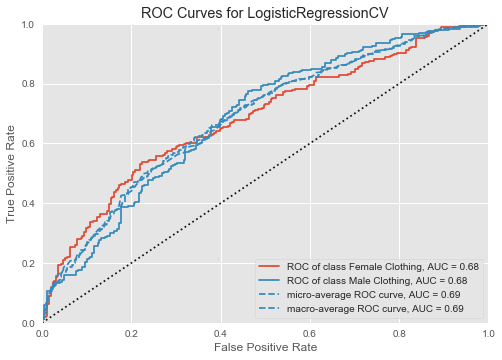

In [30]:
visualizer = ROCAUC(pca_log_reg, classes=["Female Clothing", "Male Clothing"])

visualizer.fit(pca_train, y_train)        
visualizer.score(pca_test, y_test)        
visualizer.show()


### 4.5 I decided based on better results from fewer dimesions, to pick even less features for PCA. Hence, I picked 50 components as they describe 80% of variance.

In [42]:
pca = PCA(n_components = 50, svd_solver='randomized').fit(X_train, y_train)
pca_train = pca.transform(X_train)  
pca_log_reg = LogisticRegressionCV(Cs=10, class_weight='balanced').fit(pca_train, y_train)




### Train Data

In [43]:
print(f"Classification report:\n{classification_report(y_train, pca_log_reg.predict(pca_train), target_names=labels)}")
print("Accuracy score on the training data: " + "\033[1m" + f"{round(pca_log_reg.score(pca_train, y_train)*100, 3)}%")




Classification report:
              precision    recall  f1-score   support

        Male       0.67      0.66      0.67       993
      Female       0.68      0.69      0.68      1016

    accuracy                           0.67      2009
   macro avg       0.67      0.67      0.67      2009
weighted avg       0.67      0.67      0.67      2009

Accuracy score on the training data: 67.446%


### Test Data

In [44]:
pca_test = pca.transform(X_test)

pca_pred = pca_log_reg.predict(pca_test)

print("\033[1m"+ "Logistic Regression Model PCA Performance on Test Data\n")
print("\033[0m" + f"Classification report: \n{classification_report(y_test, pca_pred, target_names=labels)}")
print("Accuracy score: " + "\033[1m" + f"{round(pca_log_reg.score(pca_test, y_test)*100, 3)}%\n")




Logistic Regression Model PCA Performance on Test Data

Classification report: 
              precision    recall  f1-score   support

        Male       0.64      0.59      0.62       249
      Female       0.63      0.68      0.65       254

    accuracy                           0.63       503
   macro avg       0.63      0.63      0.63       503
weighted avg       0.63      0.63      0.63       503

Accuracy score: 63.419%



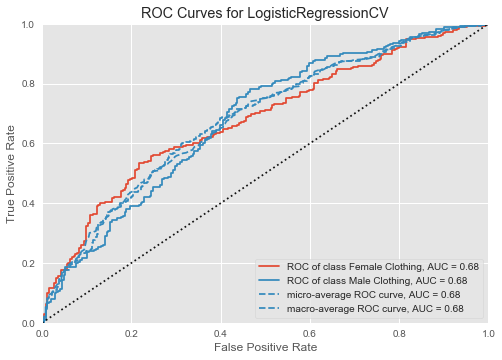

In [45]:
visualizer = ROCAUC(pca_log_reg, classes=["Female Clothing", "Male Clothing"])

visualizer.fit(pca_train, y_train)        
visualizer.score(pca_test, y_test)        
visualizer.show()

As 50 components PCA performs fairly similar to 200 components but shows less overfitting, I would chose here 50-component one as we deal with less dimensions still capturing around 80% of variance but acquire better test accuracy.

## Step 5. LDA application on the logistic regression model

### 5.1 LDA with 1 component

In [46]:
lda = LDA(n_components=1).fit(X_train, y_train)
lda_train = lda.transform(X_train) 

In [47]:
print("LDA-transformed shape of our train dataset: ", lda_train.shape[1])


LDA-transformed shape of our train dataset:  1


### 5.2 Train the Logistic Regression Model on the reduced representation that you created using PCA.

In [48]:
lda_log_reg = LogisticRegressionCV(Cs=10, class_weight='balanced').fit(lda_train, y_train)


## What is our error rate on the training data with LDA?

In [49]:
print("\033[1m"+ "Logistic Regression Model with LDA Performance on Train Data\n")
print("\033[0m" + f"An array of regularization values used for cross-validation: \n{lda_log_reg.Cs_}\n")
print(f"The regularization value mapping to the best accuracy score: \n{lda_log_reg.C_[0]}\n")
print(f"Mean cross-validation accuracy score: \n{round(np.mean(lda_log_reg.scores_[1]*100), 3)}%\n")

print(f"Classification report:\n{classification_report(y_train, lda_log_reg.predict(lda_train), target_names=labels)}")
print("Accuracy score on the training data: " + "\033[1m" + f"{round(lda_log_reg.score(lda_train, y_train)*100, 3)}%")



Logistic Regression Model with LDA Performance on Train Data

An array of regularization values used for cross-validation: 
[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]

The regularization value mapping to the best accuracy score: 
0.0001

Mean cross-validation accuracy score: 
92.658%

Classification report:
              precision    recall  f1-score   support

        Male       0.93      0.93      0.93       993
      Female       0.93      0.93      0.93      1016

    accuracy                           0.93      2009
   macro avg       0.93      0.93      0.93      2009
weighted avg       0.93      0.93      0.93      2009

Accuracy score on the training data: 92.683%


## What is our error rate on the testing data with LDA?



In [50]:
lda_test = lda.transform(X_test)

lda_pred = lda_log_reg.predict(lda_test)

print("\033[1m"+ "Logistic Regression Model LDA Performance on Test Data\n")
print("\033[0m" + f"Classification report: \n{classification_report(y_test, lda_pred, target_names=labels)}")
print("Accuracy score: " + "\033[1m" + f"{round(lda_log_reg.score(lda_test, y_test)*100, 3)}%\n")




Logistic Regression Model LDA Performance on Test Data

Classification report: 
              precision    recall  f1-score   support

        Male       0.57      0.60      0.59       249
      Female       0.59      0.56      0.57       254

    accuracy                           0.58       503
   macro avg       0.58      0.58      0.58       503
weighted avg       0.58      0.58      0.58       503

Accuracy score: 57.853%



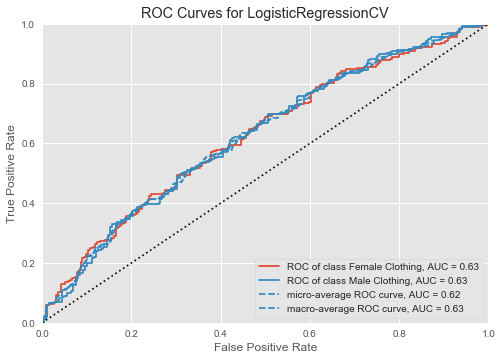

In [51]:
visualizer = ROCAUC(lda_log_reg, classes=["Female Clothing", "Male Clothing"])

visualizer.fit(lda_train, y_train)        
visualizer.score(lda_test, y_test)        
visualizer.show()

## Step 6. PCA and LDA combined

The LDA deconstruction showed that the model is overfitting. However, we can apply PCA to prevent overfitting and see if the two techniques together can produce a better performance on the test data.

In [52]:
lda_2 = LDA(n_components=1)
pca_lda_train = lda_2.fit_transform(pca_train, y_train)

In [53]:
lda_pca_log_reg = LogisticRegressionCV(Cs=10, class_weight='balanced').fit(pca_lda_train, y_train)



In [54]:
print("\033[1m"+ "Logistic Regression Model with LDA and PCA Performance on Train Data\n")
print("\033[0m" + f"An array of regularization values used for cross-validation: \n{lda_pca_log_reg.Cs_}\n")
print(f"The regularization value mapping to the best accuracy score: \n{lda_pca_log_reg.C_[0]}\n")
print(f"Mean cross-validation accuracy score: \n{round(np.mean(lda_pca_log_reg.scores_[1]*100), 3)}%\n")

print(f"Classification report:\n{classification_report(y_train, lda_pca_log_reg.predict(pca_lda_train), target_names=labels)}")
print("Accuracy score on the training data: " + "\033[1m" + f"{round(lda_pca_log_reg.score(pca_lda_train, y_train)*100, 3)}%")




Logistic Regression Model with LDA and PCA Performance on Train Data

An array of regularization values used for cross-validation: 
[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]

The regularization value mapping to the best accuracy score: 
0.005994842503189409

Mean cross-validation accuracy score: 
67.611%

Classification report:
              precision    recall  f1-score   support

        Male       0.67      0.67      0.67       993
      Female       0.68      0.68      0.68      1016

    accuracy                           0.68      2009
   macro avg       0.68      0.68      0.68      2009
weighted avg       0.68      0.68      0.68      2009

Accuracy score on the training data: 67.646%


In [55]:
pca_lda_test = lda_2.transform(pca_test)

pca_lda_pred = lda_pca_log_reg.predict(pca_lda_test)

print("\033[1m"+ "Logistic Regression Model with LDA and PCA Performance on Test Data\n")
print("\033[0m" + f"Classification report: \n{classification_report(y_test, pca_lda_pred, target_names=labels)}")
print("Accuracy score: " + "\033[1m" + f"{round(lda_pca_log_reg.score(pca_lda_test, y_test)*100, 3)}%\n")



Logistic Regression Model with LDA and PCA Performance on Test Data

Classification report: 
              precision    recall  f1-score   support

        Male       0.65      0.59      0.62       249
      Female       0.63      0.69      0.66       254

    accuracy                           0.64       503
   macro avg       0.64      0.64      0.64       503
weighted avg       0.64      0.64      0.64       503

Accuracy score: 64.016%



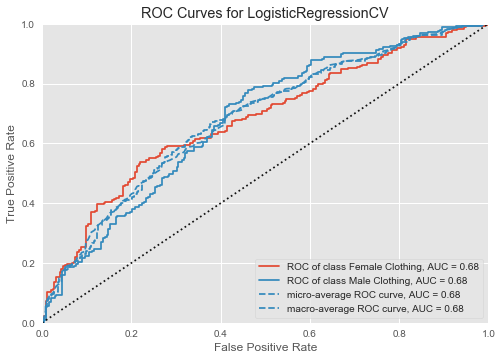

In [56]:
visualizer = ROCAUC(lda_pca_log_reg, classes=["Female Clothing", "Male Clothing"])

visualizer.fit(pca_lda_train, y_train)        
visualizer.score(pca_lda_test, y_test)        
visualizer.show()

## Step 7. Interpreting Results

|Metric|Logistic Regression |PCA|LDA| PCA & LDA
|---|---|---|---| --- | 
|Accuracy on Train Data|99.1%|67.4%|92.7%| 67.6% 
|Accuracy on Test Data|62.0%|63.4%|57.8%| 64.0% 

### Logistic Regression 

We see that the logistic regression takes the most time to run and provides the highest training accuracy. However, the test accuracy drops significantly because of overfitting the training data. We used 10-fold cross-validation and fitting of the various regularization variables to ensure we have the best model parameters. However, even with the best regularization variables, the precision and recall of the training and test data are drastically different. We also see that Male clothing has a higher recall score, indicating that the model performs better at classifying male clothes (even though there are minimal differences between male and female cloth precision). 

Lastly, ROCAUC for the regression model is 68% which is similar to PCA but higher than LDA and PCA&LDA models. This score shows that our regular regression model is 68% capable of distinguishing between male and female clothing classes.

### PCA

We used PCA to reduce the dimensions and produce better separable dataset. In case of PCA, we see best performance as accuracy of training and testing data is close to each other. We saw that first 200 feature captured around 90% of the variance in the data. Hence, we reduced the 120000-dimensional data to 200-dimensions. Reducing to lower dimesnion means means tha the chance of overfit is getting low as the chance noise would be ignored when projected onto direction of maximum variance. So, we achieved 64% in test accuracy and 71% in training which still can indicate a slight overfitting but better overall performance than all other models. ROCAUC is also as high at 68%. 

An intresting observation here is that recall for female clothes is higher than in male (in contrast to regular and LDA-enhanced model).

Additionally, the PCA-enhanced model run significantly faster that regular logistic regression. 

### LDA

We apply the supervised LDA method to maximize the distance between classes and minimize the class variance. As LDA assumes normality in the data, we have applied standard Scaller to normalize our data as the original dataset would be skewed based on the image colours and sizes (not all colours are evenly distributed throughout the set).

However, as we reduced to 1 component, we see overfitting and worst performance on test data among all models again. ROCAUD is also at the lowest 63%. Usually, LDA performs better at the classification between two classes as it selects the "most important" discriminants to describe the data. However, in this case, 1-dimension is not enough to capture fully the differences between male and female clothing (as there are a lot of similar features between both classes and a few crucially different ones).

### PCA&LDA

Lastly, I decided to extend the model by applying PCA and then LDA. In theory, this would give better performance, as LDA tends to overfit the data, and PCA can help regularize the dataset further to avoid overfitting. In our case, LDA is singular, and hence we get near-perfect class separation on the training data with poor (57%) performance on the test data. So, we initially reduce dimensions to 50 to maximize the variance in the dataset and then apply LDA to maximize the between-class separation. 

However, we get almost similar performance to PCA with 50 components both on train and test data. There is a slightly better test score:  63.4% (PCA only) vs 64% (PCA and LDA). This can be explained as we did normalize data beforehand, so additional regularization by PCA didn't contribute much to the performance of the LDA model.

## Step 8. Recommenation 

Based on the performance of our models and the time to conduct each model, I would suggest using the PCA method. This method has shown the least likelihood for overfitting and highest test performance, 63.4%. Additionally, the model takes less time to run than the regular regression model, even acquainting for the selection of the regularization values as drastically fewer components are used in the PCA method (50 vs 120000). Hence, this model would perform best out of others with newly/unseen data points.